In [1]:
# # adjsut the basic logging lovel of notebook
# import logging
# logging.basicConfig(level=logging.WARNING)

import os
import yaml
import numpy as np
import pandas as pd
import scipy as scp
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
from matplotlib.lines import Line2D
from palettable.colorbrewer import qualitative

from auditory_cortex.analyses import Correlations
from auditory_cortex import results_dir, aux_dir, saved_corr_dir, cache_dir
from auditory_cortex.utils import CorrelationUtils
from auditory_cortex.plotters.correlation_plotter import RegPlotter

from pycolormap_2d import ColorMap2DBremm, ColorMap2DZiegler
%matplotlib inline

#### bootsrap analysis...

In [2]:
def display_sessions_done(
	model_name, identifier, verbose=False, num_sessions=41, N_sents=499):
	"""Display the number of sessions done for all bin widths
	"""
	if verbose:
		print(f"For '{model_name}', '{identifier}'")
	try:
		corr_obj = Correlations(model_name+'_'+identifier)
	except:
		print(f"Model '{model_name}' with identifier '{identifier}' not found")
		return [model_name+'_'+identifier]
	bin_widths = np.sort(corr_obj.data['bin_width'].unique())
	return_list = []
	for bin_width in bin_widths:
		data = corr_obj.get_selected_data(bin_width=bin_width, N_sents=N_sents)
		if verbose:
			print(f"For bin_width: {bin_width:03} ms, sessions done: {len(data['session'].unique())}")
		if len(data['session'].unique()) != num_sessions:
			return_list.append(model_name+'_'+identifier+f'{bin_width}')
		else:
			return_list.append(None)
	return return_list

def check_bootstrap_results(
	identifier, model_names=None, bin_width=None,
	verbose=False, mVocs=False, N_sents=None
	):

	if mVocs:
		stim = 'mVocs'
		num_sessions = 39
	else:
		stim = 'timit'
		num_sessions = 12
	models_not_done = []
	if model_names is None:
		model_names = num_layers.keys()
	if bin_width is None:
		bin_width = 50
	if N_sents is None:
		N_sents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
	for model_name in model_names:
		# not_done = display_sessions_done(
		# 	model_name, identifier, verbose=verbose, num_sessions=num_sessions)
		# models_not_done.extend(not_done)
		for N in N_sents:
			not_done = display_sessions_done(
				model_name, f'{stim}_trf_lags300_bw{bin_width}_boot_{identifier}_N{N}',
				verbose=verbose, num_sessions=num_sessions, N_sents=N
				)
			models_not_done.extend(not_done)

	# remove None entries..
	while None in models_not_done:
		models_not_done.remove(None)
	
	if len(models_not_done) ==0:
		print(f"All models done..for {identifier}")
	else:
		print(f"Models with incomplete resutls:")
		for iden in models_not_done:
			print(iden)

def combine_bootstrap_results(
	identifier, model_names, bin_width=50, stim='timit', N_sents=None
	):
	"""Combines results for the list of models provided"""
	normalizer_filename = 'modified_bins_normalizer.csv'
	output_identifier = f'{stim}_trf_lags300_bw{bin_width}_boot_{identifier}'
	if N_sents is None:
		N_sents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
	for model_name in model_names:
		ids = [f'{stim}_trf_lags300_bw{bin_width}_boot_{identifier}_N{N}' for N in N_sents]
		Correlations.combine_and_ready(
			model_name,
			ids, 0, normalizer_filename=normalizer_filename,
			output_identifier=output_identifier
			)

In [7]:
model_names = [
	'whisper_base',
]
identifiers = [f'test_{i}' for i in range(10, 81)]
# identifiers[np.isin(identifiers, [29, 31, 33, 43], invert=True)]
N_sents = np.arange(1, 12)
mVocs = False
for identifier in identifiers:
	check_bootstrap_results(identifier, model_names=model_names, verbose=False, mVocs=mVocs, N_sents=N_sents)

All models done..for test_10
All models done..for test_11
All models done..for test_12
All models done..for test_13
All models done..for test_14
All models done..for test_15
All models done..for test_16
All models done..for test_17
All models done..for test_18
All models done..for test_19
All models done..for test_20
All models done..for test_21
All models done..for test_22
All models done..for test_23
All models done..for test_24
All models done..for test_25
All models done..for test_26
All models done..for test_27
All models done..for test_28
All models done..for test_29
All models done..for test_30
All models done..for test_31
All models done..for test_32
All models done..for test_33
All models done..for test_34
All models done..for test_35
All models done..for test_36
All models done..for test_37
All models done..for test_38
All models done..for test_39
All models done..for test_40
All models done..for test_41
All models done..for test_42
All models done..for test_43
All models don

In [8]:
model_names = [
	'whisper_base',
]
identifiers = [f'test_{i}' for i in range(10, 81)]
# identifiers[np.isin(identifiers, [29, 31, 33, 43], invert=True)]
N_sents = np.arange(1, 12)
for identifier in identifiers:
	combine_bootstrap_results(identifier, model_names=model_names, N_sents=N_sents)


Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boot_test_10_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boot_test_10_corr_results.csv
Writing back...!
Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boot_test_11_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boot_test_11_corr_results.csv
Writing back...!
Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boot_test_12_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boo

In [12]:
N_sents = np.arange(1, 81)

for N in N_sents:
	identifier = f"timit_trf_lags300_bw50_boot_test_{N}"
	corr_obj = Correlations('whisper_base_'+identifier)
	corr_obj.set_normalizers_using_bootsrap(mVocs=False)
	print(f"Done for {N}")

Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boot_test_1_corr_results.csv
Done for 1
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boot_test_2_corr_results.csv
Done for 2
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_timit_trf_lags300_bw50_boot_test_3_corr_results.csv
Done for 3
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/da

#### combine LPF resutls...

In [3]:
def display_sessions_done(model_name, identifier, verbose=False, num_sessions=41):
	"""Display the number of sessions done for all bin widths
	"""
	if verbose:
		print(f"For '{model_name}', '{identifier}'")
	try:
		corr_obj = Correlations(model_name+'_'+identifier)
	except:
		print(f"Model '{model_name}' with identifier '{identifier}' not found")
		return [model_name+'_'+identifier]
	bin_widths = np.sort(corr_obj.data['bin_width'].unique())
	return_list = []
	for bin_width in bin_widths:
		data = corr_obj.get_selected_data(bin_width=bin_width)
		if verbose:
			print(f"For bin_width: {bin_width:03} ms, sessions done: {len(data['session'].unique())}")
		if len(data['session'].unique()) != num_sessions:
			return_list.append(model_name+'_'+identifier+f'{bin_width}')
		else:
			return_list.append(None)
	return return_list
def check_LPF_results(identifier, model_names=None, bin_widths=None, verbose=False, mVocs=False):

	if mVocs:
		stim = 'mVocs'
		num_sessions = 39
	else:
		stim = 'timit'
		num_sessions = 41
	models_not_done = []
	if model_names is None:
		model_names = num_layers.keys()
	if bin_widths is None:
		bin_widths = [20, 40, 50, 60, 80, 100]
	for model_name in model_names:
		# not_done = display_sessions_done(
		# 	model_name, identifier, verbose=verbose, num_sessions=num_sessions)
		# models_not_done.extend(not_done)
		for bw in bin_widths:
			not_done = display_sessions_done(
				model_name, f'{stim}_trf_lags300_bw{bw}_{identifier}', verbose=verbose, num_sessions=num_sessions)
			models_not_done.extend(not_done)

	# remove None entries..
	while None in models_not_done:
		models_not_done.remove(None)
	
	if len(models_not_done) ==0:
		print(f"All models done..for {identifier}")
	else:
		print(f"Models with incomplete resutls:")
		for iden in models_not_done:
			print(iden)


def combine_results_for_all_models(identifier, model_names, bin_widths, stim):
	"""Combines results for the list of models provided"""
	normalizer_filename = 'modified_bins_normalizer.csv'
	# output_identifier = f'{stim}_trf_lags300_{identifier}'
	for model_name in model_names:

		ids = [f'{stim}_trf_lags300_bw{bw}_{identifier}' for bw in bin_widths]
		Correlations.combine_and_ready(
			model_name,
			ids, 0, normalizer_filename=normalizer_filename,
			# output_identifier=output_identifier
			)

In [22]:
model_names = [
	'deepspeech2',
	# 'whisper_tiny',
	# 'whisper_base',
	# 'wav2vec2',
	# 'wav2letter_modified',
	# 'speech2text',
]
# identifier = 'LPF_20'
identifier = 'LPF_20_80GB'
# identifier = 'LPF_20_n'
mVocs = False
bin_widths = [20, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
# bin_widths = [600, 700, 800]
check_LPF_results(identifier, model_names=model_names, bin_widths=bin_widths, verbose=True, mVocs=mVocs)

For 'deepspeech2', 'timit_trf_lags300_bw20_LPF_20_80GB'
For bin_width: 20.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw40_LPF_20_80GB'
For bin_width: 40.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw50_LPF_20_80GB'
For bin_width: 50.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw60_LPF_20_80GB'
For bin_width: 60.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw80_LPF_20_80GB'
For bin_width: 80.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw100_LPF_20_80GB'
For bin_width: 100.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw200_LPF_20_80GB'
For bin_width: 200.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw300_LPF_20_80GB'
For bin_width: 300.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw400_LPF_20_80GB'
For bin_width: 400.0 ms, sessions done: 41
For 'deepspeech2', 'timit_trf_lags300_bw500_LPF_20_80GB'
For bin_width: 500.0 ms, sessions done: 41
For 'deeps

In [23]:
model_names = [
	'deepspeech2',
	# 'whisper_tiny',
	# 'whisper_base',
	# 'wav2vec2',
	# 'wav2letter_modified',
	# 'speech2text',
]
# identifier = 'LPF_20'
identifier = 'LPF_20_80GB'
# identifier = 'LPF_20_n'
# bin_widths = [600, 700, 800]
bin_widths = [20, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
combine_results_for_all_models(identifier, model_names, bin_widths, 'timit')

Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/deepspeech2_timit_trf_lags300_bw20_LPF_20_80GB_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/deepspeech2_timit_trf_lags300_bw20_LPF_20_80GB_corr_results.csv
Writing back...!


In [25]:
model_names = [
	'deepspeech2',
	# 'whisper_tiny',
	# 'whisper_base',
	# 'wav2vec2',
	# 'wav2letter_modified',
	# 'speech2text',
]
# identifier = 'LPF_20'
# identifier = 'LPF_20_80GB'
# identifier = 'LPF_20_n'
stim = 'timit'
identifier = f'timit_trf_lags300_LPF_20'
if stim == 'mVocs':
	mVocs = True
else:
	mVocs = False
for model_name in model_names:
	corr_obj = Correlations(model_name+'_'+identifier)
	corr_obj.set_normalizers_using_bootsrap(
		mVocs=mVocs,
		norm_bin_width=20,
		)


Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/deepspeech2_timit_trf_lags300_LPF_20_corr_results.csv


In [24]:
model_names = [
	'deepspeech2',
	# 'whisper_tiny',
	# 'whisper_base',
	# 'wav2vec2',
	# 'wav2letter_modified',
	# 'speech2text',
]
ids = [
	# 'timit_trf_lags300_LPF_20',
	'timit_trf_lags300_bw20_LPF_20_80GB'
]

output_identifier = 'timit_trf_lags300_LPF_20'
for model_name in model_names:
	Correlations.combine_and_ready(
		model_name,
		ids, 0, 
		output_identifier=output_identifier
		)

Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/deepspeech2_timit_trf_lags300_LPF_20_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/deepspeech2_timit_trf_lags300_LPF_20_corr_results.csv
Writing back...!


In [ ]:
model_names = ['whisper_base']
output_identifier = 'timit_trf_lags300_LPF_20'
bin_widths = [20, 40, 50, 60, 80, 100]
identifier = f'timit_trf_lags300_bw{bw}_LPF_20_bw_{bw}'
ids = [f'timit_trf_lags300_bw{bw}_LPF_20_bw_{bw}' for bw in bin_widths]
Correlations.combine_and_ready(
	model_name,
	ids, 0, 
	output_identifier=output_identifier
	)

#### wavelet baseline...

In [12]:
model_name = 'STRF_freqs80'
# z-score normalization within Linear model
identifier = 'mVocs_trf_lags300_test_13'
 
corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[ 
	(corr_obj.data['session'] == 200206) &\
	(corr_obj.data['mVocs_normalizer'] > 0.089)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_13_corr_results.csv


0.2659557981341901

In [2]:

model_name = 'whisper_base'
# z-score normalization within Linear model
identifier = 'timit_trf_lags300_bw50_to_be_removed'
 
corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.data['session'].unique()

array([180731., 180814., 191113.])

In [11]:
model_name = 'STRF_freqs80'
# z-score normalization within Linear model
identifier = 'mVocs_trf_lags300_test_12'
 
corr_obj = Correlations(model_name+'_'+identifier)
# corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[ 
	# (corr_obj.data['session'] == 200206) &\
	(corr_obj.data['mVocs_normalizer'] > 0.089)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...


0.5189788925364995

(array([594., 382., 381.,  96.,   0.,   0.,   0.,   0.,   0., 141.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

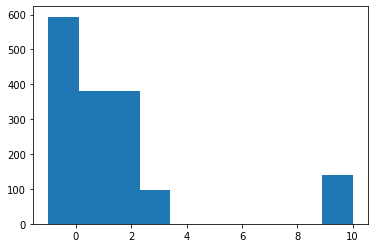

In [7]:
plt.hist(corr_obj.data['lmbda'])

In [4]:

model_name = 'whisper_tiny'
# z-score normalization
identifier = 'mVocs_trf_lags300_test_11'
 
corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[ 
	# (corr_obj.data['session'] == 200206) &\
	(corr_obj.data['mVocs_normalizer'] > 0.089)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_tiny_mVocs_trf_lags300_test_11_corr_results.csv


0.6891143485350182

In [17]:
model_name = 'STRF_freqs80'
# z-score normalization on both X and y
identifier = 'mVocs_trf_lags300_test_10'
 

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[ 
	(corr_obj.data['session'] == 200206) &\
	(corr_obj.data['mVocs_normalizer'] > 0.089)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_10_corr_results.csv


0.4965518653059973

(array([ 0.,  0.,  0.,  0.,  0., 64.,  0.,  0.,  0.,  0.]),
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5]),
 <BarContainer object of 10 artists>)

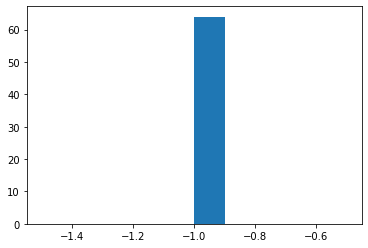

In [19]:
plt.hist(corr_obj.data['lmbda'])

In [16]:
model_name = 'STRF_freqs80'
# L2 normalization
identifier = 'mVocs_trf_lags300_test_9'
 

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[ 
	(corr_obj.data['session'] == 200206) &\
	(corr_obj.data['mVocs_normalizer'] > 0.089)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_9_corr_results.csv


0.3162590463557976

In [15]:
model_name = 'STRF_freqs80'
# min-max normalization
identifier = 'mVocs_trf_lags300_test_8'
 

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[ 
	(corr_obj.data['session'] == 200206) &\
	(corr_obj.data['mVocs_normalizer'] > 0.089)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_8_corr_results.csv


0.5171683844517782

In [14]:
model_name = 'STRF_freqs80'
# z-score normalization
identifier = 'mVocs_trf_lags300_test_7'

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[ 
	# (corr_obj.data['session'] == 200206) &\
	(corr_obj.data['mVocs_normalizer'] > 0.089)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_7_corr_results.csv


0.49264146453535906

In [13]:
model_name = 'STRF_freqs80'
# z-score normalization
identifier = 'mVocs_trf_lags300_test_7'

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[(corr_obj.data['mVocs_normalizer'] > 0.089) &\
	(corr_obj.data['session'] == 200206)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_7_corr_results.csv


0.5295891139064633

In [12]:
model_name = 'STRF_freqs80'
identifier = 'mVocs_trf_lags300_test_6'

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[(corr_obj.data['mVocs_normalizer'] > 0.089) &\
	(corr_obj.data['session'] == 200206)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_6_corr_results.csv


0.14853072607440246

In [11]:
model_name = 'STRF_freqs80'
identifier = 'mVocs_trf_lags300_test_5'

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[(corr_obj.data['mVocs_normalizer'] > 0.089) &\
	(corr_obj.data['session'] == 200206)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_5_corr_results.csv


0.44673163287247875

In [9]:
model_name = 'STRF_freqs80'
identifier = 'mVocs_trf_lags300_test_4'

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[(corr_obj.data['mVocs_normalizer'] > 0.089) &\
	(corr_obj.data['session'] == 200206)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_4_corr_results.csv


0.28479229019205404

In [8]:
model_name = 'STRF_freqs80'
identifier = 'mVocs_trf_lags300_test_3'

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[(corr_obj.data['mVocs_normalizer'] > 0.089) &\
	(corr_obj.data['session'] == 200206)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/STRF_freqs80_mVocs_trf_lags300_test_3_corr_results.csv


0.12411896531608203

In [3]:
model_name = 'spect2vec'
identifier = 'mVocs_trf_lags300_l0_test_2'

corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/spect2vec_mVocs_trf_lags300_l0_test_2_corr_results.csv


0.29700231535717336

In [5]:
corr_obj.data['session'].unique().shape

(39,)

In [10]:
model_name = 'spect2vec'
identifier = 'mVocs_trf_lags300_l0_test_1'

corr_obj = Correlations(model_name+'_'+identifier)
# corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[(corr_obj.data['mVocs_normalizer'] > 0.089) &\
	(corr_obj.data['session'] == 200206)
]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...


0.429970323851477

In [2]:

model_name = 'spect2vec'
identifier = 'mVocs_trf_lags300_l0_test_0'

corr_obj = Correlations(model_name+'_'+identifier)
# corr_obj.set_normalizers_using_bootsrap(mVocs=True)

data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/spect2vec_mVocs_trf_lags300_l0_test_0_corr_results.csv


0.328638693845316

(array([405.,   0.,   0.,   0.,   0., 863.,   0.,   0.,   0., 326.]),
 array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ]),
 <BarContainer object of 10 artists>)

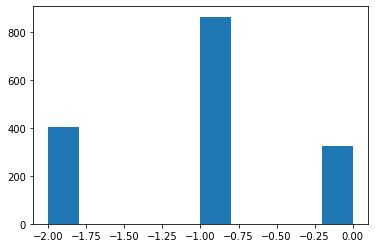

In [4]:
plt.hist(corr_obj.data['opt_lmbda'])
# plt.xlim([-2,12])

In [2]:
model_name = 'whisper_tiny'
identifier = 'mVocs_trf_lags300_gpu_l2_test_1'
# identifier = 'mVocs_trf_lags300_l2'
# identifier = 'mVocs_trf_lags300_l3'
corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)



Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_tiny_mVocs_trf_lags300_gpu_l2_test_1_corr_results.csv


In [3]:
data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

0.6766672377595775

(-2.0, 12.0)

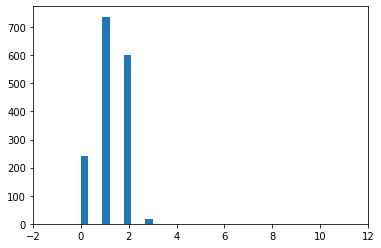

In [6]:
plt.hist(corr_obj.data['opt_lmbda'])
plt.xlim([-2,12])

#### combining results across layers...

In [8]:
num_layers = {
	'wav2letter_modified': 14,
	'deepspeech2': 7,
	'speech2text': 14,
	'whisper_tiny': 6,
	'whisper_base': 8,
	'wav2vec2': 21,
	'w2v2_audioset': 21,
	'w2v2_generic': 21,
	'w2v2_generic': 21,
	'wav2letter_spect': 12,
}


def display_sessions_done(model_name, identifier, verbose=False, num_sessions=41):
	"""Display the number of sessions done for all bin widths
	"""
	if verbose:
		print(f"For '{model_name}', '{identifier}'")
	try:
		corr_obj = Correlations(model_name+'_'+identifier)
	except:
		print(f"Model '{model_name}' with identifier '{identifier}' not found")
		return [model_name+'_'+identifier]
	bin_widths = np.sort(corr_obj.data['bin_width'].unique())
	return_list = []
	for bin_width in bin_widths:
		data = corr_obj.get_selected_data(bin_width=bin_width)
		if verbose:
			print(f"For bin_width: {bin_width:03} ms, sessions done: {len(data['session'].unique())}")
		if len(data['session'].unique()) != num_sessions:
			return_list.append(model_name+'_'+identifier+f'{bin_width}')
		else:
			return_list.append(None)
	return return_list

def check_saved_results(identifier, model_names=None, verbose=False, num_sessions=41):

	models_not_done = []
	if model_names is None:
		model_names = num_layers.keys()
	for model_name in model_names:
		# not_done = display_sessions_done(
		# 	model_name, identifier, verbose=verbose, num_sessions=num_sessions)
		# models_not_done.extend(not_done)
		for i in range(0, num_layers[model_name]):
			not_done = display_sessions_done(
				model_name, identifier+f'_{i}', verbose=verbose, num_sessions=num_sessions)
			models_not_done.extend(not_done)

	# remove None entries..
	while None in models_not_done:
		models_not_done.remove(None)
	
	if len(models_not_done) ==0:
		print(f"All models done..for {identifier}")
	else:
		print(f"Models with incomplete resutls:")
		for iden in models_not_done:
			print(iden)
	

def combine_results_for_all_models(identifier, model_names=None):
	"""Combines results for the list of models provided"""
	normalizer_filename = 'modified_bins_normalizer.csv'
	if model_names is None:
		model_names = num_layers.keys()
	for model_name in model_names:
		ids = [f'{identifier}_{i}' for i in range(0, num_layers[model_name])]
		Correlations.combine_and_ready(
			model_name,
			ids, 0, normalizer_filename=normalizer_filename,
			output_identifier=identifier
			)
		


In [6]:
model_names = [
	'whisper_tiny'
]
shuffled = False

identifier = f'ucsf_timit_trf_lags300_bw50_reimplemented'	

if 'mVocs' in identifier:
	num_sessions=39
else:
	num_sessions=41

if shuffled:
	identifier = 'reset_'+identifier
check_saved_results(identifier, model_names=model_names, verbose=True, num_sessions=num_sessions)

For 'whisper_tiny', 'ucsf_timit_trf_lags300_bw50_reimplemented_0'
For bin_width: 50.0 ms, sessions done: 41
For 'whisper_tiny', 'ucsf_timit_trf_lags300_bw50_reimplemented_1'
For bin_width: 50.0 ms, sessions done: 41
For 'whisper_tiny', 'ucsf_timit_trf_lags300_bw50_reimplemented_2'
For bin_width: 50.0 ms, sessions done: 41
For 'whisper_tiny', 'ucsf_timit_trf_lags300_bw50_reimplemented_3'
For bin_width: 50.0 ms, sessions done: 41
For 'whisper_tiny', 'ucsf_timit_trf_lags300_bw50_reimplemented_4'
For bin_width: 50.0 ms, sessions done: 41
For 'whisper_tiny', 'ucsf_timit_trf_lags300_bw50_reimplemented_5'
For bin_width: 50.0 ms, sessions done: 41
All models done..for ucsf_timit_trf_lags300_bw50_reimplemented


In [9]:
model_names = [

	'whisper_tiny',
	]
shuffled = False

identifier = f'ucsf_timit_trf_lags300_bw50_reimplemented'	
if shuffled:
	identifier = 'reset_'+identifier
combine_results_for_all_models(identifier, model_names=model_names)

Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_tiny_ucsf_timit_trf_lags300_bw50_reimplemented_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_tiny_ucsf_timit_trf_lags300_bw50_reimplemented_corr_results.csv
Writing back...!


In [10]:
model_names = [
    'whisper_tiny',

]
shuffled = False

identifier = f'ucsf_timit_trf_lags300_bw50_reimplemented'	
if 'mVocs' in identifier:
	mVocs = True
else:
	mVocs = False
if shuffled:
	identifier = 'reset_'+identifier
for model_name in model_names:
	corr_obj = Correlations(model_name+'_'+identifier)
	corr_obj.set_normalizers_using_bootsrap(mVocs=mVocs)

Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_tiny_ucsf_timit_trf_lags300_bw50_reimplemented_corr_results.csv


##### wav2letter_spect

In [3]:
model_names = [
	# 'deepspeech2',
	# 'speech2text',
    # 'whisper_tiny',
	# 'whisper_base',
	# 'wav2vec2',
	# 'wav2letter_modified',
	# 'w2v2_generic',
	'wav2letter_spect',
]
shuffled = False
# bw = 100
# identifier = f'timit_trf_lags300_bw{bw}_LPF_20_bw_{bw}'
# identifier = f'timit_trf_lags300_bw{bw}_LPF_20'

num_units = 1024
rf_list = [65, 145, 225, 785]
# rf_list = [785]
for rf in rf_list:
	identifier = f'timit_trf_lags300_bw50_units{num_units}_rf{rf}'


	if 'mVocs' in identifier:
		num_sessions=39
	else:
		num_sessions=41

	if shuffled:
		identifier = 'reset_'+identifier
	check_saved_results(identifier, model_names=model_names, verbose=True, num_sessions=num_sessions)

For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l0'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l1'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l2'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l3'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l4'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l5'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l6'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l7'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spect', 'timit_trf_lags300_bw50_units1024_rf65_l8'
For bin_width: 50.0 ms, sessions done: 41
For 'wav2letter_spe

In [5]:
model_names = [
	# 'deepspeech2',
	# 'speech2text',
    # 'whisper_tiny',
	# 'whisper_base',
	# 'wav2vec2',
	# 'wav2letter_modified',
	# 'w2v2_generic',
	'wav2letter_spect',
]
shuffled = False
# bw = 100
# identifier = f'timit_trf_lags300_bw{bw}_LPF_20_bw_{bw}'
# # identifier = 'timit_trf_lags300_bw50_naplib_matched'
num_units = 1024
rf_list = [65, 145, 225, 785]
for rf in rf_list:
	identifier = f'timit_trf_lags300_bw50_units{num_units}_rf{rf}'
	# identifier = f'mVocs_trf_lags300_bw50_units{num_units}_rf{rf}'

	if shuffled:
		identifier = 'reset_'+identifier
	combine_results_for_all_models(identifier, model_names=model_names)

Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units1024_rf65_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units1024_rf65_corr_results.csv
Writing back...!
Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units1024_rf145_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units1024_rf145_corr_results.csv
Writing back...!
Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units1024_rf225_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2le

In [6]:
model_names = [
	# 'deepspeech2',
	# 'speech2text',
    # 'whisper_tiny',
	# 'whisper_base',
	# 'wav2vec2',
	# 'wav2letter_modified',
	# 'w2v2_generic',
	'wav2letter_spect',
]
shuffled = False
# bw = 100
# identifier = f'timit_trf_lags300_bw{bw}_LPF_20_bw_{bw}'
# # identifier = 'timit_trf_lags300_bw50_naplib_matched'
# # identifier = 'mVocs_trf_lags300_bw50_naplib_matched'

num_units = 1024
rf_list = [65, 145, 225, 785]
for rf in rf_list:

	identifier = f'timit_trf_lags300_bw50_units{num_units}_rf{rf}'
	# identifier = f'mVocs_trf_lags300_bw50_units{num_units}_rf{rf}'

	# identifier = 'mVocs_trf_lags300_bw20_lmbda'
	if 'mVocs' in identifier:
		mVocs = True
	else:
		mVocs = False
	if shuffled:
		identifier = 'reset_'+identifier
	for model_name in model_names:
		corr_obj = Correlations(model_name+'_'+identifier)
		corr_obj.set_normalizers_using_bootsrap(mVocs=mVocs)

Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units1024_rf65_corr_results.csv
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units1024_rf145_corr_results.csv
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units1024_rf225_corr_results.csv
Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditor

In [16]:
# model_name = 'wav2letter_spect'
# num_units = 512
# rf = 145
# ids = [f'timit_trf_lags300_bw50_uunits{num_units}_rf{rf}']
# output_identifier = f'timit_trf_lags300_bw50_units{num_units}_rf{rf}'
# Correlations.combine_and_ready(
# 	model_name,
# 	ids, 0, normalizer_filename=None,
# 	output_identifier=output_identifier
# 	)

Combining results...
Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units512_rf145_corr_results.csv
reading from /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/wav2letter_spect_timit_trf_lags300_bw50_units512_rf145_corr_results.csv
Writing back...!


#### combining results across sessions...

In [2]:
def display_sessions_done(model_name, identifier, verbose=False):
	"""Display the number of sessions done for all bin widths
	"""
	if verbose:
		print(f"For '{model_name}', '{identifier}'")
	try:
		corr_obj = Correlations(model_name+'_'+identifier)
	except:
		print(f"identifier '{identifier}'  not found")
		return 0
	bin_width = np.sort(corr_obj.data['bin_width'].unique())[0]
	data = corr_obj.get_selected_data(bin_width=bin_width)
	if verbose:
		print(f"For bin_width: {bin_width:03} ms, sessions done: {len(data['session'].unique())}")
	return len(data['session'].unique())
	

def check_saved_results(identifier, model_names, verbose=False, num_sessions=41):

	models_not_done = []
	num_freqs = 80
	identifiers = [
		identifier,
		f'{identifier}_5_10',
		f'{identifier}_10_15',
		f'{identifier}_15_20',
		f'{identifier}_20_25',
		f'{identifier}_25_30',
		f'{identifier}_30_34',
		f'{identifier}_34_37',
		f'{identifier}_37'
	]
	
	for model_name in model_names:
		sessions_done = 0
		for iden in identifiers:
			sessions_done += display_sessions_done(
				model_name, iden, verbose=verbose)
		print(f"Total sessions done: {sessions_done}")
		if sessions_done != num_sessions:
			models_not_done.append(model_name)
			print(f"Sessions done: {sessions_done}")
		

	# remove None entries..
	while None in models_not_done:
		models_not_done.remove(None)
	
	if len(models_not_done) ==0:
		print(f"All models done..for {identifier}")
	else:
		print(f"Models with incomplete resutls:")
		for iden in models_not_done:
			print(iden)
	

def combine_results_for_all_models(identifier, model_names=None, verbose=True, num_sessions=39, force_combine=False):
	"""Combines results for the list of models provided"""
	normalizer_filename = 'modified_bins_normalizer.csv'
	for model_name in model_names:
		ids = [
			identifier,
			f'{identifier}_5_10',
			f'{identifier}_10_15',
			f'{identifier}_15_20',
			f'{identifier}_20_25',
			f'{identifier}_25_30',
			f'{identifier}_30_34',
			f'{identifier}_34_37',
			f'{identifier}_37'
			]

	
		sessions_done = 0
		valid_ids = []
		for identifier in ids:
			sess_contributed = display_sessions_done(
				model_name, identifier, verbose=verbose)
			if sess_contributed != 0:
				valid_ids.append(identifier)
			sessions_done += sess_contributed
		print(f"Total sessions done: {sessions_done}")
		if sessions_done == num_sessions or force_combine:
			Correlations.combine_and_ready(
				model_name,
				valid_ids, 0, normalizer_filename=normalizer_filename)
		else:
			# models_not_done.append(model_name)
			print(f"Sessions done: {sessions_done}")


In [3]:
identifier = 'mVocs_trf_lags300_gpu_l2'
# identifier = 'mVocs_trf_lags300_l5'
# identifier = 'mVocs_trf_lags300_l4'
# identifier = 'mVocs_trf_lags300'

model_names = [
	# 'spect2vec',
	# 'w2v2_generic'
	'whisper_tiny'
	# 'whisper_base',
	# 'wav2vec2'
	# 'speech2text'
]
check_saved_results(identifier, model_names=model_names, verbose=True, num_sessions=39)

For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l2'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 23
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l2_5_10'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l2_5_10'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l2_10_15'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l2_10_15'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l2_15_20'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l2_15_20'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l2_20_25'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l2_20_25'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l2_25_30'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l2_25_30'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l2_30_34'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l2_30_34'  not found
For 'whisper_tiny', 'mVocs_trf_lag

In [8]:
# identifier = 'mVocs_trf_lags300_l6'
identifier = 'mVocs_trf_lags300_gpu_l3'
# identifier = 'mVocs_trf_lags300_l5'
# identifier = 'mVocs_trf_lags300_l4'
# identifier = 'mVocs_trf_lags300'

model_names = [
	# 'spect2vec',
	# 'w2v2_generic'
	'whisper_tiny'
	# 'whisper_base',
	# 'wav2vec2'
	# 'speech2text'
]
force_combine = True
combine_results_for_all_models(
	identifier, model_names=model_names, verbose=True, num_sessions=39,
	force_combine=force_combine
	)


For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l3'
Using default normalizer file...
For bin_width: 50.0 ms, sessions done: 39
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l3_5_10'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l3_5_10'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l3_10_15'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l3_10_15'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l3_15_20'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l3_15_20'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l3_20_25'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l3_20_25'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l3_25_30'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l3_25_30'  not found
For 'whisper_tiny', 'mVocs_trf_lags300_gpu_l3_30_34'
Using default normalizer file...
identifier 'mVocs_trf_lags300_gpu_l3_30_34'  not found
For 'whisper_tiny', 'mVocs_trf_lag

In [9]:
model_name = 'whisper_tiny'
identifier = 'mVocs_trf_lags300_gpu_l3'
# identifier = 'mVocs_trf_lags300_l2'
# identifier = 'mVocs_trf_lags300_l3'
corr_obj = Correlations(model_name+'_'+identifier)
corr_obj.set_normalizers_using_bootsrap(mVocs=True)

Using default normalizer file...
Columns: 'mVocs_normalizer', 'mVocs_test_cc_raw', 'mVocs_normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_tiny_mVocs_trf_lags300_gpu_l3_corr_results.csv


In [ ]:
mVocs_trf_lags300_l2

#### whisper_tiny...cpu-gpu comparison

##### mVocs_trf_lags300_l2

In [27]:
data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

0.7253225965288956

##### mVocs_trf_lags300_l3

In [10]:
data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

0.647857042477037

##### mVocs_trf_lags300_gpu_l2

In [6]:
data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

0.6814670973324957

##### mVocs_trf_lags300_gpu_l3

In [7]:
data = corr_obj.data[corr_obj.data['mVocs_normalizer'] > 0.089]
np.median(data['mVocs_normalized_test_cc'])

0.6814670973324957

In [36]:
data = corr_obj.get_selected_data(
	bin_width=50, threshold=0.089, mVocs=True
	)


Applying threshold: 0.089 on column: 'mVocs_normalizer'...


(-2.0, 12.0)

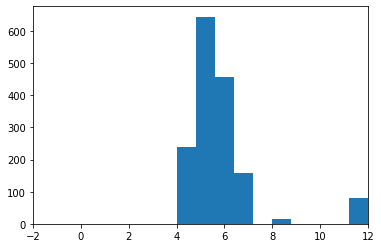

In [8]:
plt.hist(corr_obj.data['opt_lmbda'])
plt.xlim([-2, 12])

(-2.0, 12.0)

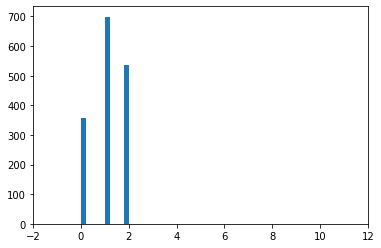

In [14]:
plt.hist(corr_obj.data['opt_lmbda'])
plt.xlim([-2, 12])

#### trf plots..

In [6]:
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
model_name = 'whisper_tiny'
identifier = 'mVocs_trf_lags300_gpu_l3'
# identifier = 'mVocs_trf_lags300_l2'
# identifier = 'mVocs_trf_lags300_l3'
corr_obj = Correlations(model_name+'_'+identifier)

Using default normalizer file...


In [3]:
corr_obj.data

,session,layer,channel,bin_width,delay,test_cc_raw,normalizer,mVocs_test_cc_raw,mVocs_normalizer,opt_lag,opt_lmbda,N_sents,layer_type,mVocs_normalized_test_cc
0,180413.0,3.0,0.0,50.0,0.0,0.0,0.0,-0.027808,-0.010759,300.0,1.0,500.0,transformer,NaN
1,180413.0,3.0,1.0,50.0,0.0,0.0,0.0,0.004237,-0.006908,300.0,1.0,500.0,transformer,NaN
2,180413.0,3.0,2.0,50.0,0.0,0.0,0.0,0.012333,-0.005825,300.0,1.0,500.0,transformer,NaN
3,180413.0,3.0,3.0,50.0,0.0,0.0,0.0,0.034322,-0.008378,300.0,1.0,500.0,transformer,NaN
4,180413.0,3.0,4.0,50.0,0.0,0.0,0.0,0.018800,-0.016484,300.0,1.0,500.0,transformer,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589,200318.0,3.0,40.0,50.0,0.0,0.0,0.0,0.208720,0.104023,300.0,1.0,500.0,transformer,0.647142
1590,200318.0,3.0,41.0,50.0,0.0,0.0,0.0,0.120013,0.060497,300.0,1.0,500.0,transformer,0.487936
1591,200318.0,3.0,42.0,50.0,0.0,0.0,0.0,0.188281,0.107575,300.0,1.0,500.0,transformer,0.574051
1592,200318.0,3.0,43.0,50.0,0.0,0.0,0.0,0.148596,0.071907,300.0,1.0,500.0,transformer,0.554142


In [ ]:
data = corr_obj.get_selected_data(
	bin_width=50, threshold=0.089, mVocs=True
	)

Plotting trained and shuffled distributions for whisper_tiny
Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Number of channels returned: (308,)
Using default normalizer file...
Extracting column: mVocs_normalized_test_cc
Applying threshold: 0.089 on column: 'mVocs_normalizer'...
Peak corr (median): 0.6814670973324957, occurs at x_coordinate: 2
Peak corr (max): 1.0722772485623768, occurs at x_coordinate: 2
Peak corr (median): 0.6814670973324957, occurs at x_coordinate: 2
Peak corr (max): 1.0722772485623768, occurs at x_coordinate: 2


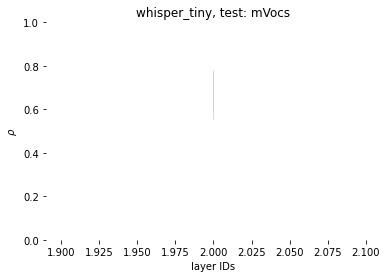

In [7]:
from auditory_cortex.plotters.tikzplots import plot_trained_vs_shuffled_network_results
model_names = [
	'whisper_tiny'
	]
# trained_identifier = 'mVocs_trf_lags300_l3'

trained_identifier = 'mVocs_trf_lags300_gpu_l2'
untrained_identifiers = [
		'mVocs_trf_lags300_gpu_l2'
						 ]
# plot_trained_vs_shuffled_network_results
tikz_indicator = 'reset-avg'
baseline_identifier = f"STRF_freqs80_mVocs"
save_tikz = False
normalized=True
# threshold=0.088
bin_width = 50
plot_trained_vs_shuffled_network_results(
		model_names=model_names,
		normalized=normalized,
		# threshold=threshold,
		untrained_identifiers = untrained_identifiers,
		trained_identifier = trained_identifier,
		# areas = ['core', 'belt', 'parabelt'],
		baseline_identifier=baseline_identifier,
		indicate_significance=False,
		plot_difference=False,
		display_dotted_lines=False,
		mVocs=True,
		save_tikz=save_tikz,
		arch_ind_lw=8,
		sig_ind_size=1,
		tikz_indicator=tikz_indicator,
		bin_width=bin_width,
		plot_baseline=False,
		use_stat_inclusion=False,
)